In [1]:
# Required imports
from langchain.document_loaders import UnstructuredMarkdownLoader, NotebookLoader
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from typing import List, Dict
from datetime import datetime
import glob
from dotenv import load_dotenv, find_dotenv
import os
from IPython.display import display, Markdown

In [2]:
# Load environment variables
load_dotenv(find_dotenv())

True

In [3]:
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)

# System message template
system_template = """You are a specialized AI assistant focused on demand forecasting and related topics. Your role is to:
- Provide accurate, well-structured responses based on given context
- Always cite sources using [Source X] format
- Maintain focus on demand forecasting topics
- Be transparent about information limitations
- Structure responses logically and clearly
- Ensure every significant statement has a source citation"""

# Human message template
human_template = """Use the following context to answer the question:

Context: {context}

Question: {question}

Please follow these guidelines in your response:
1. Use ONLY information from the provided context
2. ALWAYS cite your sources using [Source X] format where X is the source number
3. If multiple sources support a statement, cite all relevant sources: [Source 1,2]
4. If the context doesn't contain enough information, clearly state that
5. Structure your response in a clear, logical manner

Remember: Every significant statement must have a source citation."""

In [4]:
chat_prompt = ChatPromptTemplate(
    input_variables=["context", "question"],
    messages=[
        SystemMessagePromptTemplate.from_template(system_template),
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template(human_template),
    ],
)

In [5]:
context = """[Source 1]
The retail industry has seen significant changes in demand forecasting methods over the past decade. Machine learning models have shown a 25% improvement in accuracy compared to traditional statistical methods. The most successful retailers are using a combination of historical sales data, weather patterns, and social media trends to predict demand.

[Source 2]
A 2023 study by RetailTech Research showed that companies using AI-driven demand forecasting reduced their inventory costs by 30% and improved stock availability by 22%. The study covered 150 retail chains across North America and Europe.

[Source 3]
Seasonal factors remain crucial in retail demand forecasting. The study found that 78% of fashion retailers who incorporated seasonal indices in their forecasting models achieved better accuracy rates. However, the COVID-19 pandemic disrupted traditional seasonal patterns, requiring new approaches to forecasting.

[Source 4]
Real-time data integration has become essential for modern demand forecasting. Retailers who update their forecasts daily based on POS data show 15% better accuracy than those using weekly updates. Mobile data and social media trends are now being used as leading indicators for demand shifts."""

# Initial question to test
question_1 = "What are the main benefits of using AI in retail demand forecasting, and how has it impacted inventory management?"

question_2 = "Can you elaborate more on how seasonal factors affect these AI-driven forecasting models?"

In [6]:
# Format the prompt messages
prompt_messages = chat_prompt.format_messages(
    context="",
    question=question_1,
    chat_history=[],
)

In [ ]:
from typing import Dict, List, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)


class InputState(TypedDict):
    messages: List
    context: str
    question: str


class PrivateState(TypedDict):

    prompt_messages: str
    chat_history: str
    ai_message: str


class OutputState(TypedDict):
    pass
    # answer: str


class GraphState(InputState, PrivateState, OutputState):
    pass


# # Define our state
# class GraphState(TypedDict):
#     messages: List
#     context: str
#     question: str
#     prompt_messages: str
#     chat_history: str
#     ai_message: str

In [ ]:
def extract_chat_history(state: GraphState) -> GraphState:
    """Extract relevant chat history from messages."""
    chat_history = []
    for msg in state["messages"]:
        if isinstance(msg, (HumanMessage, AIMessage)):
            chat_history.append(msg)

    # Store chat history in state for next node
    state["chat_history"] = chat_history
    print(f"CHat History: {chat_history}")
    return state


def format_prompt(state: GraphState) -> GraphState:
    """Format the prompt with context, question and chat history."""
    # Initialize chat_history if it doesn't exist
    if "chat_history" not in state:
        state["chat_history"] = []

    # Format the prompt messages
    prompt_messages = chat_prompt.format_messages(
        context=state["context"],
        question=state["question"],
        chat_history=state["chat_history"],
    )
    print(f"PROMPT MESSAGE: \n {prompt_messages}")

    # Store formatted prompt in state for next node
    state["prompt_messages"] = prompt_messages
    return state


def get_llm_response(state: GraphState) -> GraphState:
    """Get response from LLM using the formatted prompt."""
    print(f"PROMPT MESSAGE: \n {state['prompt_messages']}")
    llm = ChatOpenAI(temperature=0.7)

    # Use the prompt messages to get a response
    ai_message = llm.invoke(state["prompt_messages"])

    # Store AI message in state for next node
    state["ai_message"] = ai_message
    print(f"AI MESSAGE: {ai_message}")
    return state


def update_message_history(state: GraphState) -> GraphState:
    """Update message history with new question and response."""
    # Add the new messages to the state
    state["messages"].append(HumanMessage(content=state["question"]))
    # if "ai_message" in state:
    state["messages"].append(state["ai_message"])

    # Clean up temporary state variables if desired
    if "chat_history" in state:
        del state["chat_history"]
    if "prompt_messages" in state:
        del state["prompt_messages"]
    if "ai_message" in state:
        del state["ai_message"]

    return state

In [10]:
def handle_irrelevant_question(state: GraphState) -> GraphState:
    """Handle questions not relevant to demand forecasting."""
    state["messages"].append(HumanMessage(content=state["question"]))
    state["messages"].append(
        AIMessage(
            content="I'm specialized in demand forecasting. Your question appears to be outside my area of expertise."
        )
    )
    return state


def check_context_relevance(state: GraphState) -> str:
    """Check if the context is relevant to the question."""
    # Simple keyword matching for demo purposes
    keywords = ["forecast", "demand", "retail", "inventory"]
    if any(keyword in state["question"].lower() for keyword in keywords):
        return "RELEVANT"
    return "NOT_RELEVANT"

In [11]:
def build_graph():
    # Initialize the graph
    graph = StateGraph(GraphState)

    # Add the nodes
    graph.add_node("extract_chat_history", extract_chat_history)
    graph.add_node("format_prompt", format_prompt)
    graph.add_node("get_llm_response", get_llm_response)
    graph.add_node("update_message_history", update_message_history)
    graph.add_node("handle_irrelevant_question", handle_irrelevant_question)

    # Set the entry point
    graph.set_entry_point("extract_chat_history")

    # Add conditional edges first (before any direct edges)
    graph.add_conditional_edges(
        "extract_chat_history",
        check_context_relevance,
        {"RELEVANT": "format_prompt", "NOT_RELEVANT": "handle_irrelevant_question"},
    )

    # Add the remaining edges in sequence
    graph.add_edge("format_prompt", "get_llm_response")
    graph.add_edge("get_llm_response", "update_message_history")
    graph.add_edge("handle_irrelevant_question", END)
    graph.add_edge("update_message_history", END)

    # Compile the graph
    return graph.compile()

In [12]:
graph = build_graph()

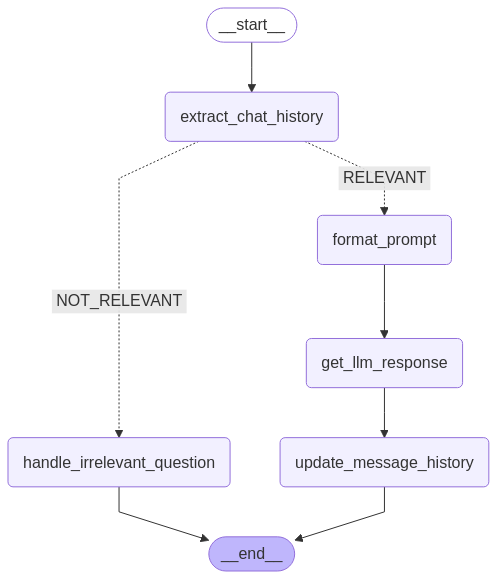

In [13]:
graph

In [14]:
# Usage example
def query_system(question, context, messages=None):
    if len(messages) or messages is None:
        messages = [SystemMessage(content=system_template)]

    # Create the initial state
    state = {"messages": messages, "context": context, "question": question}

    # Run the graph - use the correct method
    result = graph.invoke(state)  # Changed from invoke() to run()

    return result

In [15]:
# Run the graph with your input state
result_state = graph.invoke(
    {
        "messages": [],
        "context": context,
        "question": "What are the main benefits of using AI in retail demand forecasting?",
    }
)

# Get the last message (which is the AI's response)
last_message = result_state["messages"][-1]

# If you want just the content of the message
response_content = last_message.content

display(Markdown(f"AI Response: {response_content}"))

CHat History: []
PROMPT MESSAGE: 
 [SystemMessage(content='You are a specialized AI assistant focused on demand forecasting and related topics. Your role is to:\n- Provide accurate, well-structured responses based on given context\n- Always cite sources using [Source X] format\n- Maintain focus on demand forecasting topics\n- Be transparent about information limitations\n- Structure responses logically and clearly\n- Ensure every significant statement has a source citation', additional_kwargs={}, response_metadata={}), HumanMessage(content="Use the following context to answer the question:\n\nContext: [Source 1]\nThe retail industry has seen significant changes in demand forecasting methods over the past decade. Machine learning models have shown a 25% improvement in accuracy compared to traditional statistical methods. The most successful retailers are using a combination of historical sales data, weather patterns, and social media trends to predict demand.\n\n[Source 2]\nA 2023 study

AI Response: Using the provided context, the main benefits of using AI in retail demand forecasting are:

1. **Improved Accuracy**: Retail companies utilizing AI-driven demand forecasting experience a 25% increase in accuracy compared to traditional statistical methods [Source 1].

2. **Cost Reduction and Stock Availability Improvement**: According to a study by RetailTech Research, companies employing AI-driven demand forecasting reduced their inventory costs by 30% and enhanced stock availability by 22% [Source 2].

3. **Enhanced Seasonal Forecasting**: Incorporating seasonal factors in demand forecasting models significantly improves accuracy rates, as demonstrated by 78% of fashion retailers who utilized seasonal indices [Source 3].

4. **Adaptation to Disruptions**: AI enables retailers to adapt to disruptions like the COVID-19 pandemic, which can disrupt traditional seasonal patterns, by allowing for the incorporation of new data and approaches into forecasting models [Source 3].

5. **Real-time Data Integration**: Retailers benefit from incorporating real-time data, such as POS data, mobile data, and social media trends, into their demand forecasting processes. This integration leads to 15% better accuracy when forecasts are updated daily compared to weekly updates [Source 4]. 

In conclusion, AI-driven demand forecasting in retail offers improved accuracy, cost reduction, enhanced stock availability, better seasonal forecasting, adaptation to disruptions, and the integration of real-time data for more accurate predictions.

In [16]:
result_state = graph.invoke(
    {
        "messages": [],
        "context": context,
        "question": question_2,
    }
)

# Get the last message (which is the AI's response)
last_message = result_state["messages"][-1]

# If you want just the content of the message
response_content = last_message.content

display(Markdown(f"AI Response: {response_content}"))

CHat History: []
PROMPT MESSAGE: 
 [SystemMessage(content='You are a specialized AI assistant focused on demand forecasting and related topics. Your role is to:\n- Provide accurate, well-structured responses based on given context\n- Always cite sources using [Source X] format\n- Maintain focus on demand forecasting topics\n- Be transparent about information limitations\n- Structure responses logically and clearly\n- Ensure every significant statement has a source citation', additional_kwargs={}, response_metadata={}), HumanMessage(content="Use the following context to answer the question:\n\nContext: [Source 1]\nThe retail industry has seen significant changes in demand forecasting methods over the past decade. Machine learning models have shown a 25% improvement in accuracy compared to traditional statistical methods. The most successful retailers are using a combination of historical sales data, weather patterns, and social media trends to predict demand.\n\n[Source 2]\nA 2023 study

AI Response: Seasonal factors play a crucial role in AI-driven demand forecasting models, impacting their accuracy and effectiveness [Source 3]. Incorporating seasonal indices into forecasting models has been shown to improve accuracy rates for retail demand forecasting, especially in industries like fashion [Source 3]. However, the COVID-19 pandemic has disrupted traditional seasonal patterns, challenging the effectiveness of these models and necessitating the adoption of new forecasting approaches [Source 3]. 

Incorporating seasonal factors into AI-driven forecasting models is essential for understanding and predicting demand fluctuations based on specific time periods or seasons. This consideration allows retailers to adjust their inventory levels and marketing strategies accordingly, improving overall forecasting accuracy and inventory management [Source 3].

In [ ]:
# # Initialize with system message
# initial_messages = [SystemMessage(content=system_template)]

# # Process a query
# result = query_system(
#     "What are the main benefits of using AI in retail demand forecasting?",
#     context,
#     initial_messages,
# )

In [ ]:
# display(Markdown(result_state["messages"][-1].content))

Seasonal factors play a crucial role in AI-driven demand forecasting models, impacting their accuracy and effectiveness [Source 3]. Incorporating seasonal indices into forecasting models has been shown to improve accuracy rates for retail demand forecasting, especially in industries like fashion [Source 3]. However, the COVID-19 pandemic has disrupted traditional seasonal patterns, challenging the effectiveness of these models and necessitating the adoption of new forecasting approaches [Source 3]. 

Incorporating seasonal factors into AI-driven forecasting models is essential for understanding and predicting demand fluctuations based on specific time periods or seasons. This consideration allows retailers to adjust their inventory levels and marketing strategies accordingly, improving overall forecasting accuracy and inventory management [Source 3].